In [4]:
import torch
import torch.nn as nn
import torchvision.io
import torch.nn.functional as F
import pandas
import numpy as np
import matplotlib.pyplot as plt
import kornia.color
from matplotlib import colors

blocksize=120
gridsize=8
gridcells=(int)(blocksize/gridsize)

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

#Convolution block wrapper, autopadding
class convblk(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation='none'):
        super().__init__()
        self.in_channels, self.out_channels, self.kernel_size, self.stride = in_channels, out_channels, kernel_size, stride
        self.convolute = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.kernel_size//2)
        self.activate = activation_func(activation)
        self.batchnorm = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        x = self.convolute(x)
        x = self.activate(x)
        x = self.batchnorm(x)
        return x

class deconvblk(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation='none'):
        super().__init__()
        self.in_channels, self.out_channels, self.kernel_size, self.stride = in_channels, out_channels, kernel_size, stride
        self.convolute = nn.ConvTranspose2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.kernel_size//2)
        self.activate = activation_func(activation)
        self.batchnorm = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        x = self.convolute(x)
        x = self.activate(x)
        x = self.batchnorm(x)
        return x

class resblk(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation='none'):
        super().__init__()
        self.in_channels, self.out_channels, self.kernel_size, self.stride = in_channels, out_channels, kernel_size, stride
        self.convolute1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.kernel_size//2)
        self.convolute2 = nn.Conv2d(self.out_channels, self.out_channels, self.kernel_size, 1, self.kernel_size//2)
        self.activate1 = activation_func(activation)
        self.activate2 = activation_func(activation)
        self.batchnorm1 = nn.BatchNorm2d(self.in_channels)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        self.propagate = nn.Conv2d(self.in_channels, self.out_channels, 1, self.stride, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(self.in_channels)
    def forward(self, x):
        res = self.batchnorm3(x)
        res = self.propagate(res)
        x = self.batchnorm1(x)
        x = self.activate1(x)
        x = self.convolute1(x)
        x = self.batchnorm2(x)
        x = self.activate2(x)
        x = self.convolute2(x)
        x += res
        return x


class convStack(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, depth=1, block=resblk, activation='none'):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.blocks = nn.Sequential(block(in_channels, out_channels, kernel_size, stride, activation),\
            *[block(out_channels, out_channels, kernel_size, 1, activation) for _ in range(depth - 1)])
      
    def forward(self, x):
        x = self.blocks(x)
            
        return x
        
CHANNEL_SCALE = 32
ACTIVATION = 'leaky_relu'
class smoothBrain(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = convStack(6, 6, 1, 1, 1, activation=ACTIVATION)
        self.layer2 = convStack(6, CHANNEL_SCALE, 7, 4, 3, activation=ACTIVATION)
        self.layer3 = convStack(CHANNEL_SCALE, CHANNEL_SCALE*2, 3, 1, 3, activation=ACTIVATION)
        self.layer4 = convStack(CHANNEL_SCALE*2, CHANNEL_SCALE*2, 3, 1, 20, activation=ACTIVATION)
        self.layer5 = convStack(CHANNEL_SCALE*2, CHANNEL_SCALE*4, 3, 3, 40, activation=ACTIVATION)
        self.pool = nn.AvgPool2d(4,4)
        self.fc1 = nn.Linear(16*CHANNEL_SCALE, gridcells*gridcells*3)

    def forward(self, x):
        src = x
        #x = x[:,None]
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = x.view(-1,gridcells*gridcells,3)
    
        return(vectoimg(x, src))
    
    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

class smoothBrainRaw(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = convStack(6, 6, 1, 1, 1, activation=ACTIVATION)
        self.layer2 = convStack(6, CHANNEL_SCALE, 7, 4, 3, activation=ACTIVATION)
        self.layer3 = convStack(CHANNEL_SCALE, CHANNEL_SCALE*2, 3, 1, 3, activation=ACTIVATION)
        self.layer4 = convStack(CHANNEL_SCALE*2, CHANNEL_SCALE*2, 3, 1, 15, activation=ACTIVATION)
        self.layer5 = convStack(CHANNEL_SCALE*2, CHANNEL_SCALE*4, 3, 3, 40, activation=ACTIVATION)
        self.pool = nn.AvgPool2d(4,4)
        self.fc1 = nn.Linear(16*CHANNEL_SCALE, blocksize*blocksize*3)

    def forward(self, x):
        src = x
        #x = x[:,None]
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = x.view(-1,3,blocksize,blocksize)
        return(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



#Loss functions
class loss_wrapper(torch.nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.loss_func = loss_func
    
    def forward(self, x, y):
        return self.loss_func(x,y)

#Classifier
def hinge_loss(x, y):
    loss = 1 - x * y
    return torch.mean(torch.where(loss < 0, torch.zeros_like(loss), loss))

def mispredict_loss(x,y):
    loss = - x * y
    return torch.mean(torch.where(loss < 0, torch.zeros_like(loss), loss))

def incorrect(x,y):
    return torch.sum(x*y < 0) / len(x)

#Regression
def MSE_loss(x, y):
    loss = torch.pow(y - x, 2)
    return torch.mean(loss)

def MAE_loss(x, y):
    return torch.mean(torch.abs(y - x))


def l2_regularizer(model, loss, strength):
    def reg_loss(x, y):
        return loss(x,y) + strength * torch.sum(torch.pow(torch.cat([param for param in model.parameters()]),2))
    return reg_loss

def l1_regularizer(model, loss, strength):
    def reg_loss(x, y):
        return loss(x,y) + strength * torch.sum(torch.abs(torch.cat([param for param in model.parameters()])))
    return reg_loss

def rbf(x, z, gamma):
    return torch.exp(- gamma * torch.sum(torch.pow(x-z,2), dim=-1))

def kernel_mat(kernel, x, **kwargs):
    return kernel(x[:,None,:] , x[None,:,:], **kwargs)

In [25]:
def vectoimg(vectors, source):
    device = vectors.get_device()
    if device == -1:
        device = "cpu"
    grid = torch.stack(list(torch.meshgrid(torch.arange(0,gridsize*2./blocksize,2./blocksize),torch.arange(0,gridsize*2./blocksize,2./blocksize))),dim=2).to(device)
    grid = torch.flatten(grid,0,1)
    vectors = torch.unsqueeze(vectors, -2)
    ratio = torch.sigmoid(vectors[:,:,:,-1]).view(-1,gridcells,gridcells)
    blocks = grid + vectors[:,:,:,:-1]
    blocks = blocks.view(*blocks.shape[:2],gridsize,gridsize,2)
    pred = torch.empty(len(vectors), 3, blocksize, blocksize).to(device)
    if (torch.sum(blocks.isnan()) > 0):
        print("CONTAINS NAN")
    for i in range(gridcells):
        for j in range(gridcells):
            pred[:,:,i*gridsize:(i+1)*gridsize,j*gridsize:(j+1)*gridsize] = ratio[:,i,j,None,None,None]* F.grid_sample(source[:,:3], blocks[:,i*gridcells+j]+torch.tensor([-1+i*gridsize*2./blocksize,-1+j*gridsize*2./blocksize],device=device)) + (1-ratio[:,i,j,None,None,None]) *F.grid_sample(source[:,3:], blocks[:,i*gridcells+j]+torch.tensor([-1+i*gridsize*2./blocksize,-1+j*gridsize*2./blocksize],device=device))
    return torch.flip(torch.rot90(pred,3,(-1,-2)),(-2,))

def upscaleVid(vid, model):
    vid = torchvision.io.read_video(vid,0,10,pts_unit='sec')[0]
    mapped = kornia.color.rgb_to_yuv(torch.swapaxes(torch.swapaxes(vid,2,3),1,2)/256)
    x = (int) (np.ceil(mapped.shape[-1]/blocksize))
    y = (int) (np.ceil(mapped.shape[-2]/blocksize))
    smooth = torch.empty((mapped.shape[0]-1,*mapped.shape[1:]))
    for i in range(y):
        for j in range(x):
            topleft = torch.tensor([i * blocksize, j * blocksize])
            bottomright = torch.min(torch.tensor(mapped.shape[2:]), topleft + torch.tensor([blocksize, blocksize]))
            size = bottomright-topleft
            features = torch.zeros((mapped.shape[0]-1, 6, blocksize, blocksize))
            features[:,:3,:size[0],:size[1]] = mapped[:-1,:,topleft[0]:bottomright[0],topleft[1]:bottomright[1]]
            features[:,3:,:size[0],:size[1]] = mapped[1:,:,topleft[0]:bottomright[0],topleft[1]:bottomright[1]]
            smooth[:,:,topleft[0]:bottomright[0],topleft[1]:bottomright[1]] = model(features).detach()[:,:,:size[0],:size[1]] 
            
    smooth = torch.swapaxes(torch.swapaxes(kornia.color.yuv_to_rgb(smooth),1,2),2,3)*256
    output = torch.empty((2*vid.shape[0]-1,*vid.shape[1:]))
    for i in range(len(smooth)):
        output[2*i] = vid[i]
        output[2*i+1] = smooth[i]
    torchvision.io.write_video("Test.mp4",output,60)

In [26]:
upscaleVid("mov_bbb.mp4",net)

/opt/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [6]:
def learn(net, optimizer, loss_func, X, y, batch_size=50, device='cpu'):

    torch.backends.cudnn.fastest = True
    calc = loss_func
    net.train()
    totalloss=0
    indicies = torch.randperm(len(X))
    batches = int(np.floor(len(X)/batch_size))
    for batch in range(batches):
        optimizer.zero_grad()
        tx = X[indicies[batch*batch_size:(batch+1)*batch_size]].to(device)
        ty = y[indicies[batch*batch_size:(batch+1)*batch_size]].to(device)
        pred = net(tx)
      
        loss = calc(pred, ty)
        totalloss += loss.detach()
        loss.backward()
        optimizer.step()
    loss = totalloss/batches
    return loss.item()

def test(net, loss_func, X, y, batch_size=50, device='cpu'):

    calc = loss_func
    net.eval()
    totalloss=0
    batches = int(np.floor(len(X)/batch_size))
    for batch in range(batches):
        tx = X[batch*batch_size:(batch+1)*batch_size].to(device)
        ty = y[batch*batch_size:(batch+1)*batch_size].to(device)
        pred = net(tx).detach()

        totalloss += calc(pred, ty)
    loss = totalloss/batches
    return loss.item()

from IPython import display
def plot_train(trainloss, testloss):
    #plt.clf()
    plt.plot(np.linspace(2,len(trainloss),len(trainloss)-1), trainloss[1:], label="train")
    plt.plot(np.linspace(2,len(testloss),len(testloss)-1), testloss[1:], label="test")
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss') 
    #display.display(plt.gcf())
    #plt.savefig('CNN-Direct30L.png')
    plt.show()
    #display.clear_output(wait=True)


def train(model, optimizer, loss, X, y, validation_size, batch_size=100, epochs=1, plot=False, verbose=False, metric=mispredict_loss):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    ind = np.random.permutation(len(y))
    validationX = X[ind[:validation_size]]
    validationy = y[ind[:validation_size]]
    trainX = X[ind[validation_size:]]
    trainy = y[ind[validation_size:]]
    train_loss = []
    validation_loss = []
    plt.ion()
    epoch = 0
    for i in range(epochs):
        train_loss.append(learn(model, optimizer, loss, trainX, trainy, batch_size=batch_size, device=device))
        validation_loss.append(test(model, loss, validationX, validationy, batch_size=batch_size, device=device))
        if(verbose):
            print("Epoch:", i+1)
            print("Train loss:", train_loss[i])
            print("validation loss:", validation_loss[i])
        epoch += 1
        print(train_loss[-1])
    if(plot):
        plot_train(train_loss,validation_loss)
    Err = test(model, loss_wrapper(metric), validationX, validationy, batch_size=batch_size, device=device)
    print("Average Error (MAE): " + str(Err))
    

In [7]:
vid = torch.swapaxes(torch.swapaxes(torchvision.io.read_video("mov_bbb.mp4",0,10,pts_unit='sec')[0],2,3),1,2)/256
mapped = kornia.color.rgb_to_yuv(vid)

In [8]:
randlocx = torch.randint(0,mapped.shape[3]-blocksize, (mapped.shape[0],))
randlocy = torch.randint(0,mapped.shape[2]-blocksize, (mapped.shape[0],))
features = torch.empty((mapped.shape[0]-2,2*mapped.shape[1],blocksize,blocksize))
targets = torch.empty((mapped.shape[0]-2,mapped.shape[1],blocksize,blocksize))
for i in range(mapped.shape[0]-2):
    features[i,:mapped.shape[1]] = mapped[i,:,randlocy[i]:randlocy[i]+blocksize,randlocx[i]:randlocx[i]+blocksize]
    features[i,mapped.shape[1]:] = mapped[i+2,:,randlocy[i]:randlocy[i]+blocksize,randlocx[i]:randlocx[i]+blocksize]
    targets[i] = mapped[i+1,:,randlocy[i]:randlocy[i]+blocksize,randlocx[i]:randlocx[i]+blocksize]

/opt/miniconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


0.013850118033587933
0.007940790615975857
0.005908687599003315
0.004220178816467524
0.003774016397073865
0.0032788680400699377
0.002336913486942649
0.001828968757763505
0.0015422964934259653
0.0012290213489905
0.0009176174644380808
0.0008042629924602807


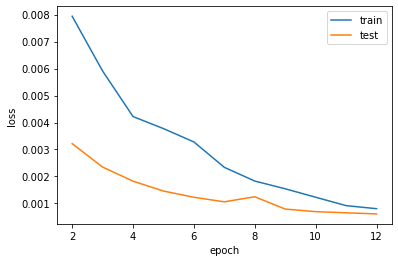

Average Error (MAE): 4.085954969923478e-06


/opt/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [9]:
net = smoothBrain()
optim = torch.optim.Adam(net.parameters(), 0.0002)
train(net, optim, MSE_loss, features, targets, 50, 20, epochs=12, plot=True)

<Figure size 432x288 with 0 Axes>

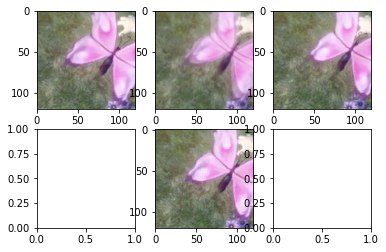

In [10]:
frame = 29
net = net.to("cpu")
img = net(features[frame:frame+1]).detach()[0]


# grid = torch.stack(list(torch.meshgrid(torch.arange(0,gridsize*2./blocksize,2./blocksize),torch.arange(0,gridsize*2./blocksize,2./blocksize))),dim=2)
# grid = torch.flatten(grid,0,1)
# blocks = grid - 0.99
# print(blocks.shape)
# blocks = blocks.view(1,10,10,2)
# img = F.grid_sample(features[frame:frame+1,:3], blocks)[0]

plt.figure()
fig, subplot = plt.subplots(2,3) 
subplot[0,0].imshow(torch.swapaxes(torch.swapaxes(kornia.color.yuv_to_rgb(features[frame,:3]),0,2),0,1))
subplot[0,1].imshow(torch.swapaxes(torch.swapaxes(kornia.color.yuv_to_rgb(img),0,2),0,1))
subplot[0,2].imshow(torch.swapaxes(torch.swapaxes(kornia.color.yuv_to_rgb(features[frame,3:]),0,2),0,1))
subplot[1,1].imshow(torch.swapaxes(torch.swapaxes(kornia.color.yuv_to_rgb(targets[frame]),0,2),0,1))
